In [1]:
import sys
sys.path.append("..")

from qiskit.providers.fake_provider import Fake27QPulseV1, Fake5QV1, Fake20QV1
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from src.state_of_the_art.sabre import run_sabre
from src.state_of_the_art.cirq import run_cirq,from_backend_to_edges
from src.state_of_the_art.pytket import run_pyket
from src.state_of_the_art.qmap import run_qmap
from src.isl_routing.mapping.routing import POLY_QMAP
from src.isl_routing.utils.isl_data_loader import *
from src.isl_routing.utils.circuit_utils import *
from src.visiualisation.plots import *
from time import time


In [2]:
"""
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(instance="ibm-q/open/main")
 
backend = service.backend("ibm_sherbrooke")


backend_name = backend.name
edges = backend.configuration().coupling_map

"""
edges = FakeSherbrooke().configuration().coupling_map

In [7]:
results_swaps = {
    "sabre" : [],
    "qmap": [],
    "cirq": [],
    "pytket":[],
    "closure": [],
}

results_depth = {
    "sabre":[],
    "qmap": [],
    "cirq": [],
    "pytket":[],
    "closure": [],
}

In [8]:
from tqdm import tqdm
for i in range(100, 400, 100):
    for j in tqdm(range(10), desc=f"Processing QSE {i}CYC", leave=False):
        file_path = f"../benchmarks/polyhedral/queko-bss-16qbt/16QBT_{i}CYC_QSE_{j}.json"
        data = json_file_to_isl(file_path)   
        
        qmap_result = run_qmap(data,edges,initial_mapping="trivial")  
        results_swaps["qmap"].append(qmap_result["swaps"])
        results_depth["qmap"].append(qmap_result["depth"])
        
        cirq = run_cirq(data["qasm_code"],edges=edges,initial_mapping="trivial")  
        results_swaps["cirq"].append(cirq["swaps"])
        results_depth["cirq"].append(cirq["depth"])
        
        pytket_results = run_pyket(data,edges,initial_mapping="trivial")
        results_swaps["pytket"].append(pytket_results["swaps"])
        results_depth["pytket"].append(pytket_results["depth"])
        
        poly_mapper = POLY_QMAP(edges, data)
        poly_mapper.run(heuristic_method="closure",initial_mapping_method="trivial")
        results_swaps["closure"].append(poly_mapper.results[0]['swap_count'])
        results_depth["closure"].append(poly_mapper.results[0]['circuit_depth'])
        
        
        
        sabre = run_sabre(data, edges,layout="trivial")  
        results_swaps["sabre"].append(sabre["swap_count"])
        results_depth["sabre"].append(sabre["circuit_depth"])




In [9]:
plot_performance(results_swaps,results_depth)

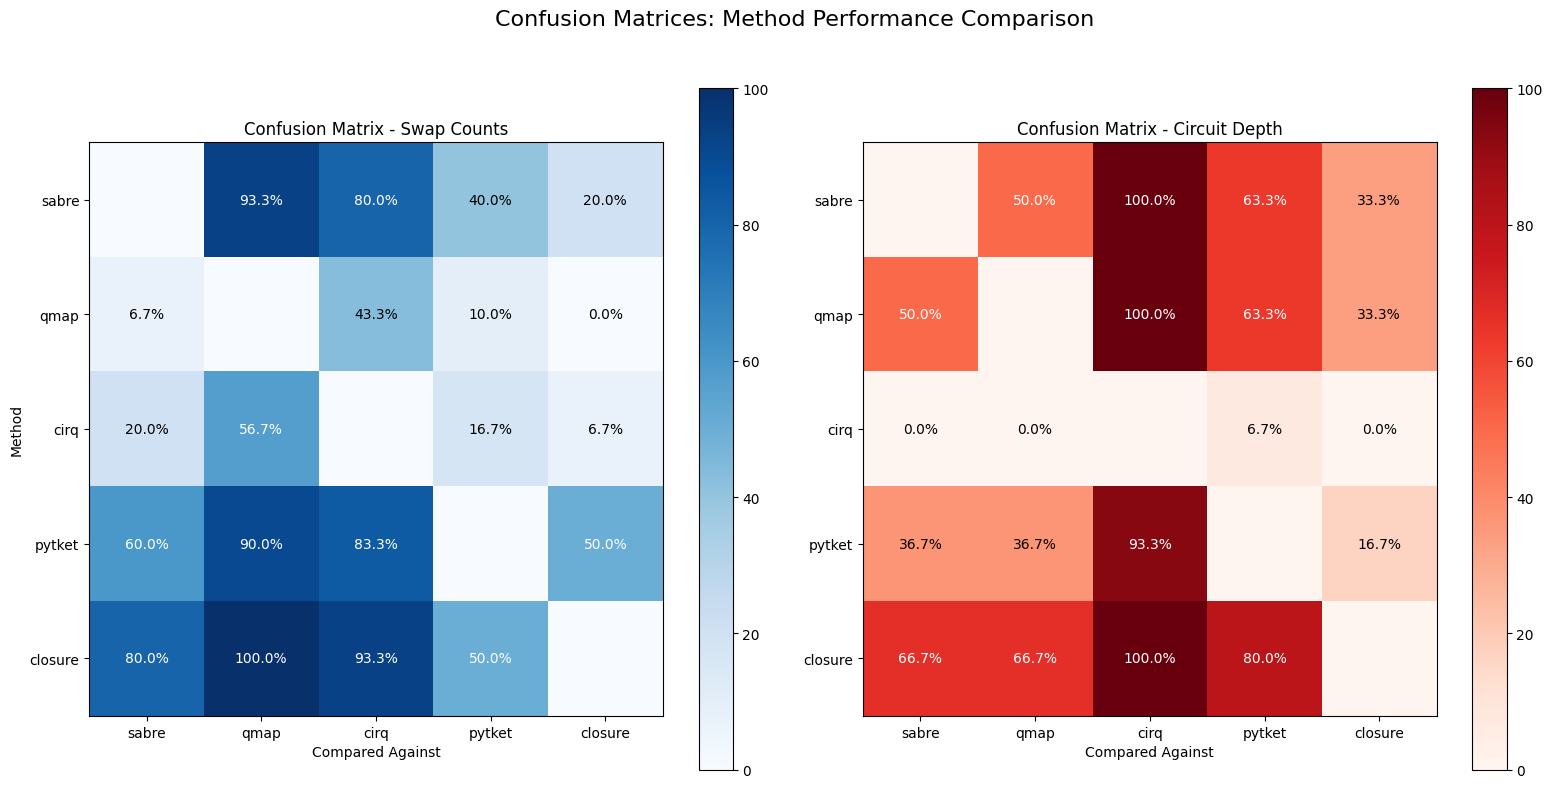

In [10]:
plot_confusion_matrices(results_swaps,results_depth)